# Data Science Project Final Report
**By: Ricky Shi, Evan Chen, Mari Yasui, Shon Hoang**

---
# Introduction
### Data Description/Background


This project explores the player behavior using a dataset collected by a UBC Computer Science research group that ran a Minecraft server. As players joined and interacted with the world, the server recorded their individual information. This includes their age, name, gender, how many hours they played in total, their experience level, and whether they were subscribed to a game-related newsletter. 


This project uses two datasets, `players.csv` and `sessions.csv`. Our analysis will primarily use `players.csv`, as it includes both predictors and the response variable. 

Below is a brief description of the dataset:

| Variable | Type | Description |
| --- | --- | --- |
| experience | factor | self-reported experience level (Amateur, Veteran, Regular, Behinner, Pro) |
| subscribe | logical | whether the player is subscribed to the newsletter |
| hashedEmail | character | a unique anonymized ID for each player |
| played_hours | numeric | total hours played by the player |
| name | character | the player's first name |
| gender | factor | the player's gender |
| Age | numeric | the player's age |

The variables *experience and gender* have been changed to categorical variables to better aid in further data-visualization.


| Dataset | Rows | Columns | Description |
|----------|------|----------|--------------|
| `players.csv` | 196 | 7 | Contains hashed emails (acts as player IDs) and variables such as age, gender, total playtime (hours), and newsletter subscription status |

**Potential Issues**
- Missing age for two players reduces usable data
- Extreme playtime values (e.g., idle sessions) may report inaccurate playtimes
- Subscription classes are imbalanced (many more “Yes” than “No”)
- Predictors use different scales and must be standardized

## Establishing the Question

**Broad Question:**  
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do they differ between various player types?

**Specific Question:**  
The specific question we aim to answer using this dataset is: <b>Can a player’s age and total playtime predict whether they subscribe to the game’s newsletter?</b> 
The goal of this question is to see whether a player’s age and total number of played hours are useful indicators of whether they choose to subscribe to the game’s newsletter. 

To answer this question, we use the `players.csv` dataset, which contains a row per player and several columns that describe their characteristics. The variables/columns we focus on are:

- Subscribe (factor), which indicates whether the player is subscribed to the newsletter</li>
- Age (numeric), which indicates the player’s age in years</li>
- Played_hours (numeric), which indicates the total number of hours the player played on the server</li>


In [1]:
library(tidyverse)
library(tidymodels)
library(themis)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Methods and Results

Below is some summary statistics of the `players.csv` dataset:

In [2]:
# Load Data and summarize
players <- read_csv("https://github.com/FunkyMonkey245/dsci_project_planning_individual/raw/refs/heads/main/data/players.csv", show_col_types = FALSE) |>
    mutate(
        experience = as_factor(experience),
        gender = as_factor(gender),
        Age = as.integer(Age)
        )


players_summary <- players |>
    summarize(
        total_players = n(),
        subscribed_players = sum(subscribe == TRUE, na.rm = TRUE),
        unsubscribed_players = sum(subscribe == FALSE, na.rm = TRUE),
        subscribed_percent = round(100 * subscribed_players / total_players, 2),
        age_mean = round(mean(Age, na.rm = TRUE), 2),
        age_min  = min(Age, na.rm = TRUE),
        age_max  = max(Age, na.rm = TRUE),
        hours_mean = round(mean(played_hours, na.rm = TRUE), 2),
        hours_min  = min(played_hours, na.rm = TRUE),
        hours_max  = max(played_hours, na.rm = TRUE)
      )

head(players)
players_summary

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


total_players,subscribed_players,unsubscribed_players,subscribed_percent,age_mean,age_min,age_max,hours_mean,hours_min,hours_max
<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
196,144,52,73.47,21.14,9,58,5.85,0,223.1


**Summary Report: `players.csv`**

- Total players: 196
- Subscribed players: 144
- Unsubscribed players: 52
- Percent Subscribed: 73.47%
- Average player age: 21.14 years
- Youngest player: 9 years
- Oldest player: 58 years
- Average total playtime: 5.85 hours
- Lowest playtime: 0 Hours
- Highest playtime: 223.10 Hours

## Exploratory Data Analysis and Visualization

- For this section, we will use the `players.csv` dataset to summarize the mean of the predictor variables and visualize their relationships with newsletter subscription in multiple plots.
- We added additional visualizations that contained variables we are not directly using to answer the question, just for the purposes of exploring their relationships with our target response variable. 
- Not much wrangling is needed as the dataset is already tidy for the analysis

In [3]:
# Mean summary of predictor variables
mean_summary <- players |>
    summarize(
        mean_age = round(mean(Age, na.rm = TRUE), 2),
        mean_playtime = round(mean(played_hours, na.rm = TRUE), 2),
      )

mean_summary

mean_age,mean_playtime
<dbl>,<dbl>
21.14,5.85


**Plots Included**
- Scatterplot of age vs. playtime colored by subscription
- Bar plot comparing subscription counts across experience levels
- Histograms showing playtime distribution for subscribers vs non-subscribers
- Log10 scaling was applied to playtime variables to compress extreme values and clearly show clustered data
- Second bar plot showing proportion of players subscribed and not subscribed in each gender category

**Observations**
- Most players recorded under 10 hours of total playtime
- There is a weak negative relationship between age and playtime, where younger players tend to play more
- Subscribed players generally show more total playtime
- Amateurs and veterans have the most subscribers

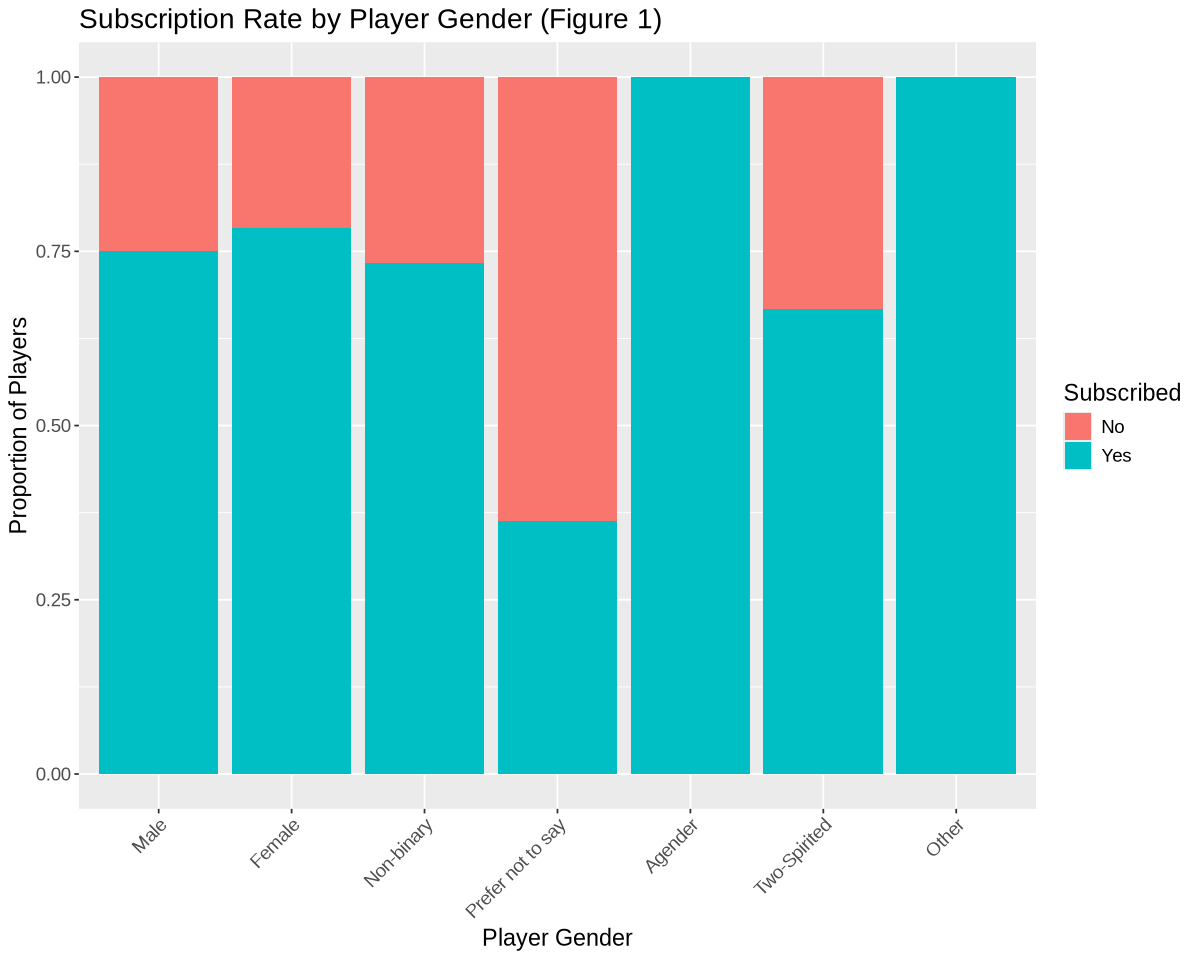

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


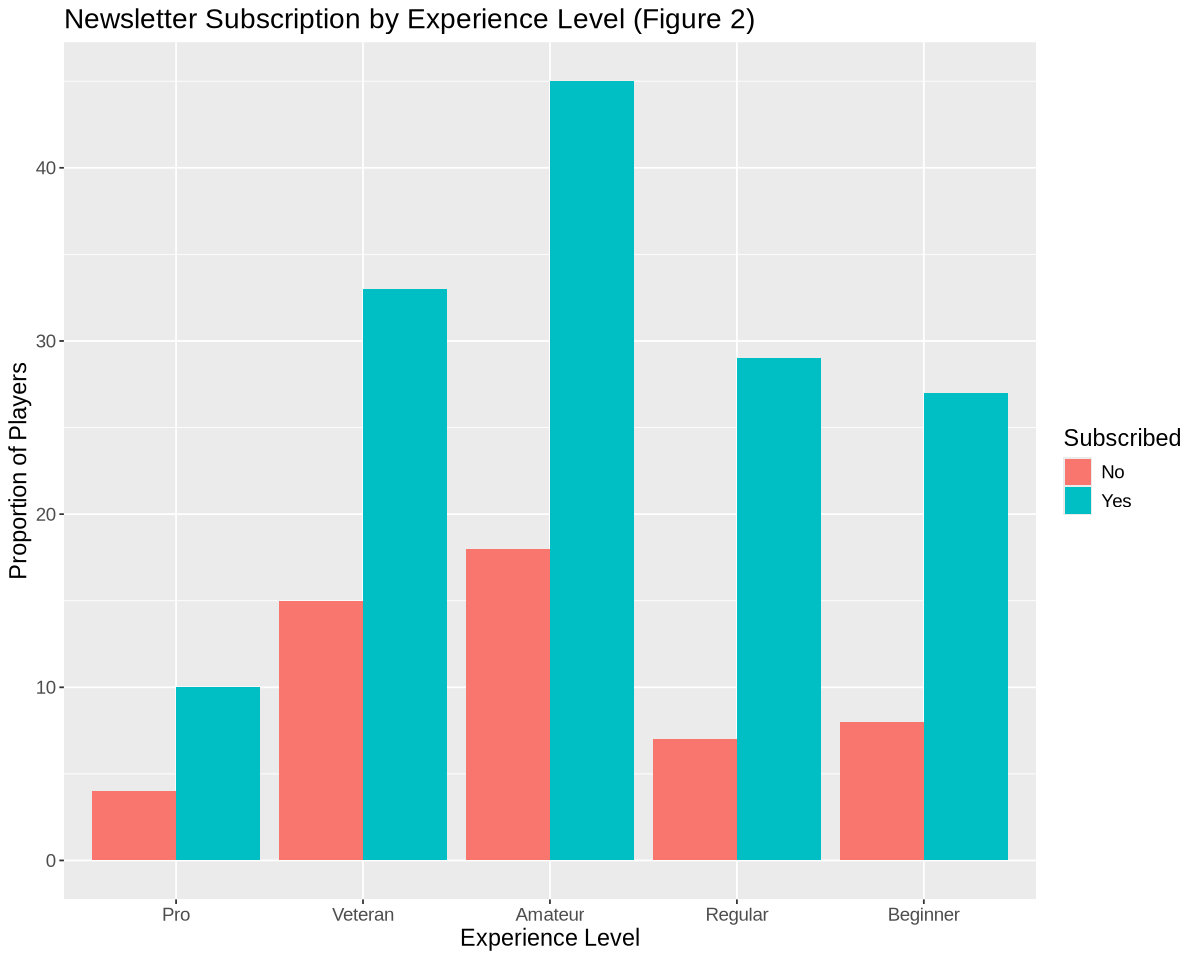

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


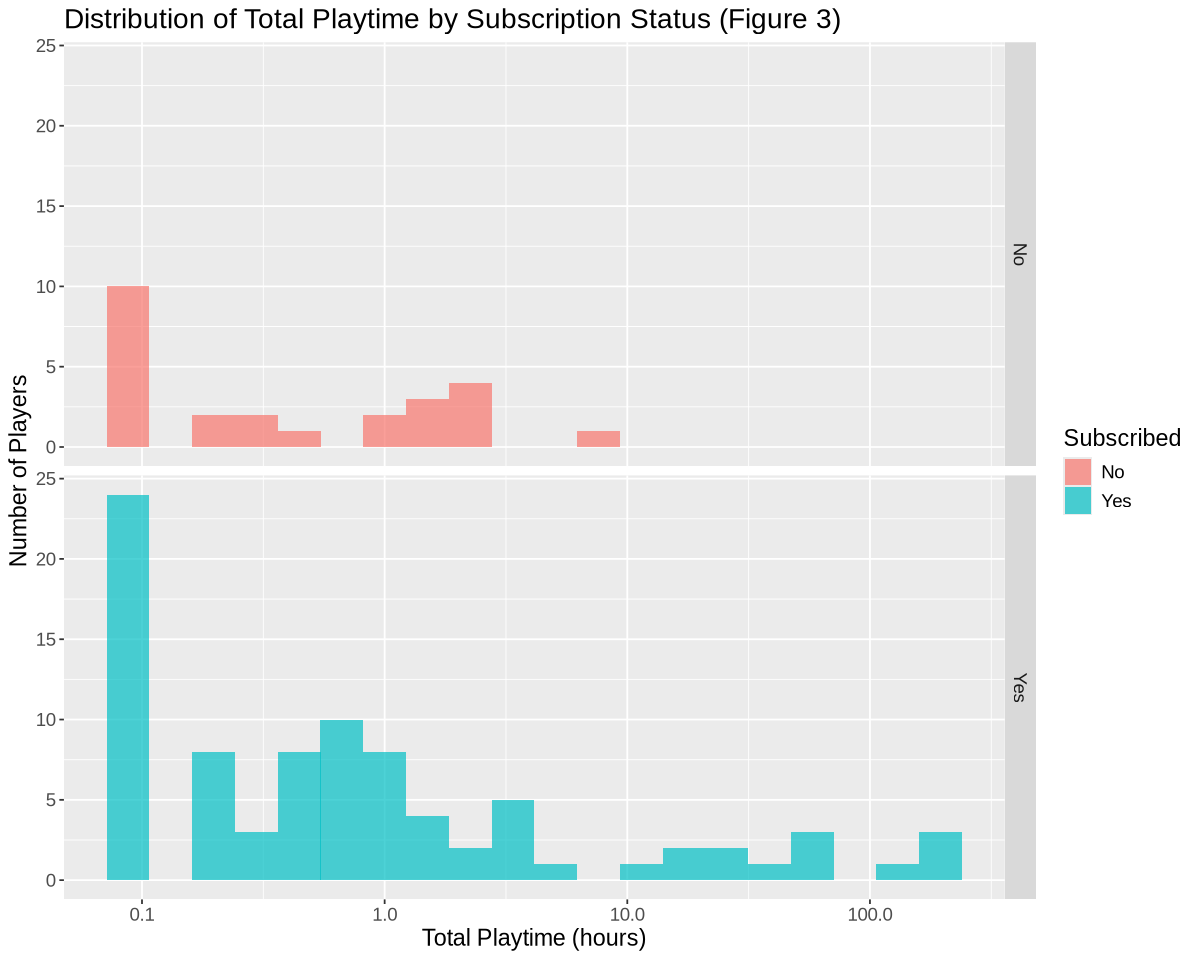

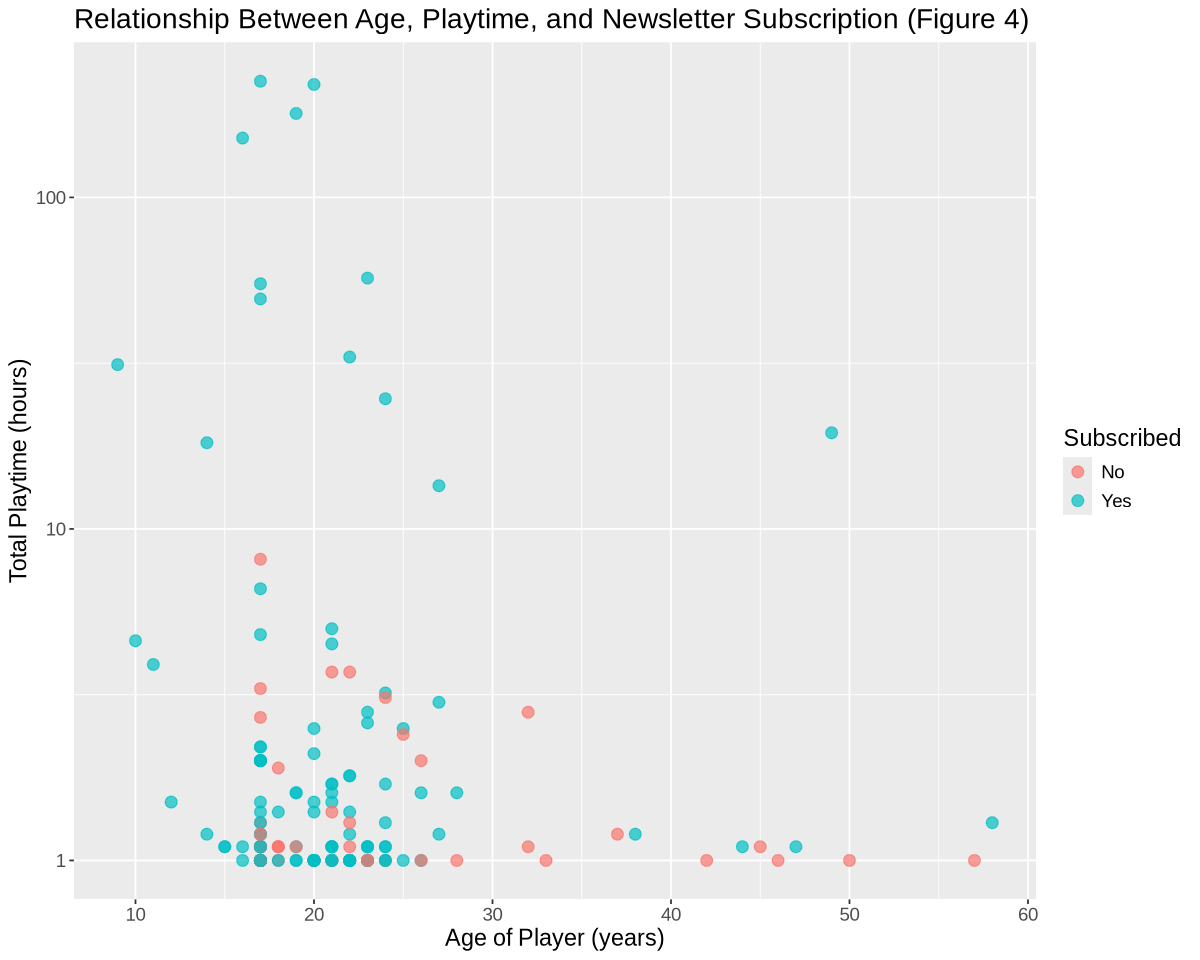

In [9]:
options(repr.plot.width = 10, repr.plot.height = 8)

#Data is already quite tidy, so changing the variable types is sufficient for my analysis

players <- players |>
    mutate(subscribe = as_factor(subscribe), subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"), experience = as_factor(experience))

# Plot visualizations showing the relationships between multiple variables in the players dataset

players_plot <- ggplot(players, aes(x = Age, y = played_hours + 1, color = subscribe)) +
    geom_point(alpha = 0.7, size = 3) +
    scale_y_log10() +
    labs(x = "Age of Player (years)", y = "Total Playtime (hours)", color = "Subscribed") +
    ggtitle("Relationship Between Age, Playtime, and Newsletter Subscription (Figure 4)") +
    theme(text = element_text(size = 14))

players_barplot <- ggplot(players, aes(x = experience, fill = subscribe)) +
    geom_bar(position = "dodge") +
    labs(title = "Newsletter Subscription by Experience Level (Figure 2)", x = "Experience Level", y = "Proportion of Players", fill = "Subscribed") +
    theme(text = element_text(size = 14))

players_histogram <- ggplot(players, aes(x = played_hours, fill = subscribe)) +
    geom_histogram(bins = 20, alpha = 0.7, position = "identity") +
    facet_grid(rows = vars(subscribe)) +
    scale_x_log10() +
    labs(title = "Distribution of Total Playtime by Subscription Status (Figure 3)", x = "Total Playtime (hours)", y = "Number of Players", fill = "Subscribed") +
    theme(text = element_text(size = 14))

gender_sub_plot <- players |>
  ggplot(aes(x = gender, fill = subscribe)) +
  geom_bar(position = "fill") + 
  labs(
    title = "Subscription Rate by Player Gender (Figure 1)",
    x = "Player Gender",
    y = "Proportion of Players",
    fill = "Subscribed"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(text = element_text(size = 14))

gender_sub_plot
players_barplot
players_histogram
players_plot 

## Data Analysis

The method we used to investigate our specific question was the K-nearest neighbours (KNN) classification model. We began by splitting the data into 70% training and 30% testing sets. Since KNN relies on distance calculations, we created a recipe for the predictors that centered and scaled both Age and played_hours so that they are on the same scale. 

Next, we defined a KNN model with the number of neighbours set to tune(). We then performed a 5-fold cross-validation on the training set to compare the different values of K, evaluating K values ranging from 1 to 25. We chose accuracy as our main metric because our analysis does not consider the importance of false positives, false negatives, etc. so precision and recall were not used to find the best K. For each value of K, we computed the mean accuracy across all 5 folds. 

## Finding K

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_impute_mean()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,accuracy,binary,0.7354497,5,0.005291005,Preprocessor1_Model17
19,accuracy,binary,0.7354497,5,0.005291005,Preprocessor1_Model19
21,accuracy,binary,0.7354497,5,0.005291005,Preprocessor1_Model21
22,accuracy,binary,0.7354497,5,0.005291005,Preprocessor1_Model22
23,accuracy,binary,0.7354497,5,0.005291005,Preprocessor1_Model23
24,accuracy,binary,0.7354497,5,0.005291005,Preprocessor1_Model24


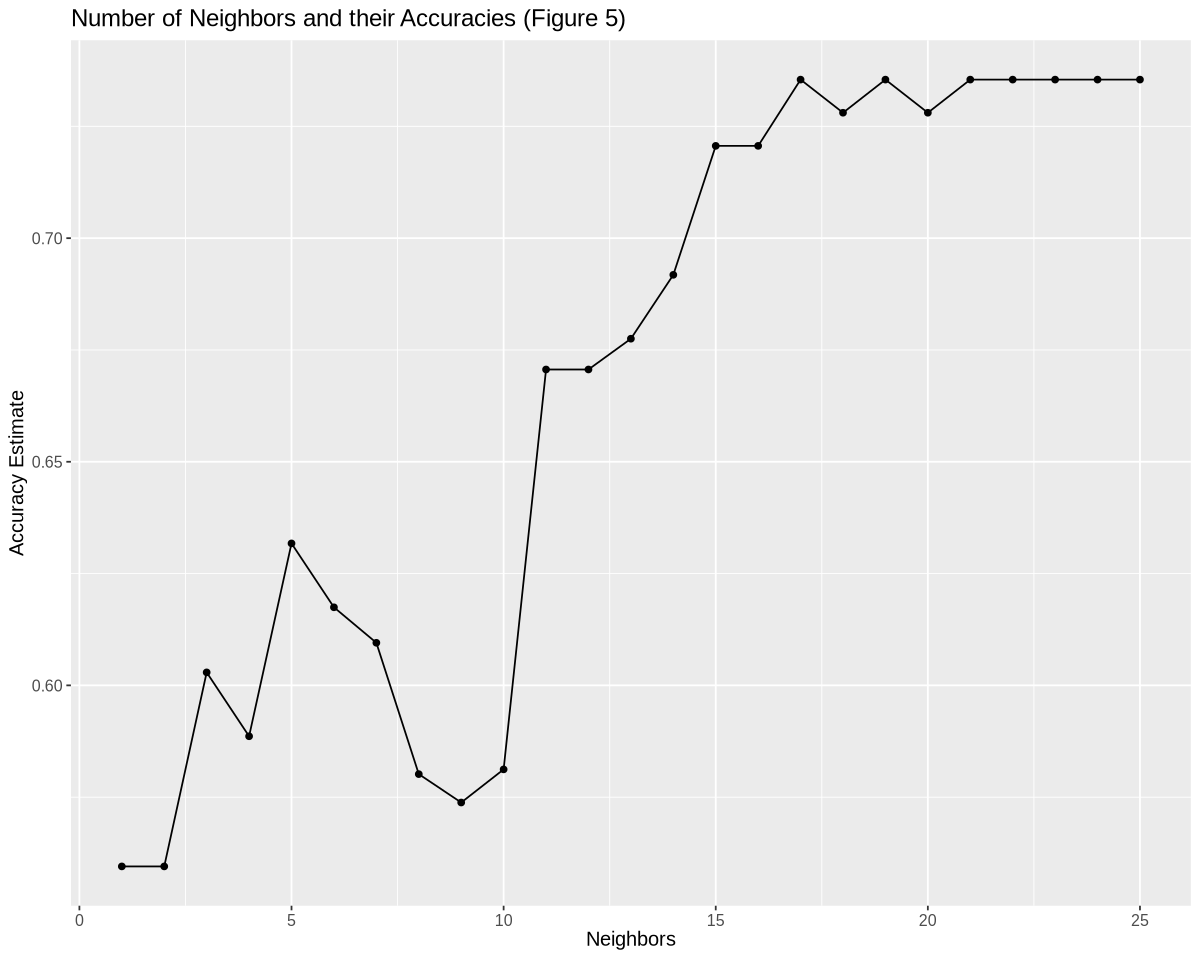

In [26]:
set.seed(2025)

players_split <- initial_split(players, prop = 0.70, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
  step_impute_mean(all_predictors()) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 

players_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

players_wkflw <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

players_wkflw

k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

highest_accuracy <- accuracies |>
  slice_max(mean, n = 1)

head(highest_accuracy)

Accuracy_graph <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Number of Neighbors and their Accuracies (Figure 5)") +
  theme(text = element_text(size = 12))

Accuracy_graph


In [28]:
players_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  fit(data = players_train)

players_fit

players_test_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)

players_test_metrics <- players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_test_metrics


players_test_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "first")

players_test_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "first")

confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_impute_mean()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3602941
Best kernel: rectangular
Best k: 5

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5333333


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.2692308


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.4375


          Truth
Prediction No Yes
       No   7  19
       Yes  9  25

## Results

Our results were then visualized using a line plot that showed accuracy vs K. The plot illustrates a clear increase in mean accuracy for values of K up until ~20, where the mean value levels off and stays constant. We decided to use K = 5 even though K = 17 is the highest accuracy K value because the value of K was too large, causing underfitting. This is because, as K increases to large numbers, more and more of the data points have a "say" in the prediction, which sways the results towards the majority class. Since our dataset had a 73% imbalance of yes cases over no, our model is then sensitive to underfitting. We also experimented with step_upsample() in our recipe to improve the 73% yes/no class imbalance, but that method gave the best value of K as K = 2, and an accuracy of 36.7%, far worse than without up-sampling. K = 5 was the highest validation accuracy without causing underfitting, so it is the optimal number of neighbors for this model. Using K = 5, we made a new model specification using that value of K, retrained it, and fit it to the entire training dataset. We then evaluated its performance on the test set and achieved an accuracy value of around 53%. We additionally evaluated other metrics such as precision and recall, along with a confusion matrix to further explore how well our model performed. Overall, all three metrics yielded rather insignificant results. 


# Discussion & Conclusion

After using a K-nearest neighbor (KNN) classifier, the accuracy of the model in predicting the subscription status of a player based on their age and play time was found to be 53.3%. This means that the model correctly predicted whether a player subscribed only roughly half the time. This suggests that our two variables, age and total playtime, contain little to no meaningful information about subscription behaviour. This result does not align with what we observed in Figure 4. We hypothesized that our variables would have an effect on subscription because of the trends seen in the visualization. Playtime shows a clear trend, as players with higher total playtime are more likely to be subscribers. The relationship with age is less obvious, but it may still may somewhat contribute when combined with playtime in the model. 

In summary, our findings suggest that total playtime and age are likely not useful for predicting whether a player would subscribe to the game’s newsletter. The imbalanced classes in the `players.csv` dataset made it difficult to find a meaningful K value. A potential impact of our results is that the game’s developers or platform managers could avoid advertising game newsletters only based on age and total playtime as the basis, as our analysis concluded that these two predictors do not have a substantial impact on determining subscription status.

In the future, we can incorporate other predictor variables found in the players.csv dataset, and or the sessions.csv dataset to improve the model’s accuracy. This could tell us which variables could be the best indicators of subscription, as our current choice of total playtime and age might not be the strongest predictors. Some potential future questions could be: 
- Does the player's experience level meaningfully affect the likelihood of subscription to the newsletter?
- Using the sessions.csv dataset, can we use the number of played sessions to determine whether the player is likely to be subscribed to the newsletter?
